# DATA

In [1]:
%load_ext autoreload
%autoreload 2
import genericIO
import SepVector
import Hypercube
import numpy as np
import Operator
import WEM

import time

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [13]:

n1 = 200
n2 = 200 

d1 = 20
d2 = 10

o1 = 0
o2 = 0

slow = SepVector.getSepVector(Hypercube.hypercube(ns=[n1,n2],ds=[d1,d2],os=[o1,o2]),storage='dataComplex')

slowNd = slow.getNdArray()
slowNd[:] = 1/2000*1/2000
slowNd[int(1.5*n2/3)::,:] = 1/3000*1/3000

In [14]:
import json

ns = 3
par = {
    "ns" : ns,
    "dsx" : 100,
    "osx" : 500,
    "dsz" : 0,
    "osz" : 500,
    
    "nr" : 201,
    "drx" : 20,
    "orx" : 0,
    "drz" : 0,
    "orz" :  1000,
    
    "fmin" : 1, 
    "fmax" : 15,  
    "nfreq" : 10,
    
    "nref" : 3,
    "tap" : 100,
    "pad" : 100,
    "ngs" : 0,
    "ngr" : 0,
    "prop" : 'ssf',
    "eps" : 0.01,
    
    "ntaylor" : 1,
    "onepass" : 0,
    "cmap" : 0,
    
}


ot = 0
tmax = 3
dt = 0.004
nt = int((tmax-ot) / dt)
wave = SepVector.getSepVector(Hypercube.hypercube(ns=[nt],ds=[dt],os=[ot]))
waveNd = wave.getNdArray()
t = np.linspace(ot,tmax,nt) - .5
f0 = 5
waveNd[:] = (1-2*(np.pi*f0*t)**2)* np.exp(-(np.pi*f0*t)**2)
print(waveNd.shape)
# waveNd = np.roll(waveNd,-int(0.5/dt))

data = SepVector.getSepVector(Hypercube.hypercube(ns=[nt,par["nr"],par["ns"]],ds=[dt,par["drx"],par["dsx"]],os=[ot,par["orx"],par["osx"]]))
datNd = data.getNdArray()

parObj = genericIO.pythonParams(par)

(750,)


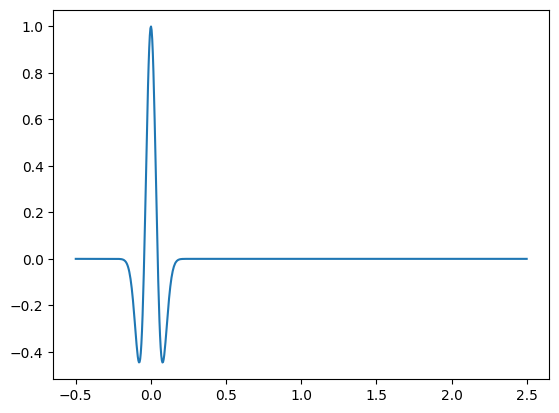

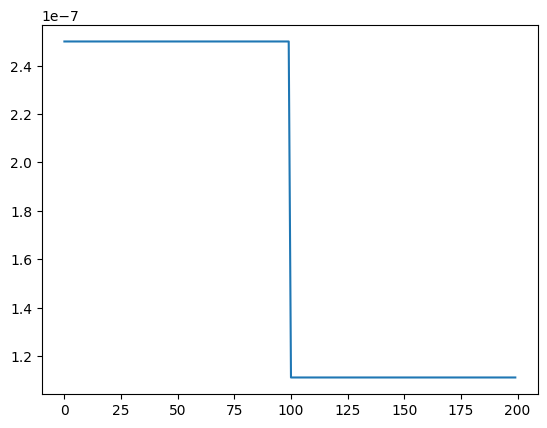

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t,waveNd)

plt.figure()
plt.plot(slow[:,0])

In [16]:
wem = WEM.WEM(slow,data,wave,parObj)

wem.forward(False,slow,data)


fmin = 1; fmax = 15.3525
nfreq = 44; from imin = 2 to imax = 45
nshots = 3; nrec = 201
Propagating shots ... 
8.40725 s


In [18]:
slow.scale(10)
wem.forward(False, slow, data)

Propagating shots ... 
8.66202 s


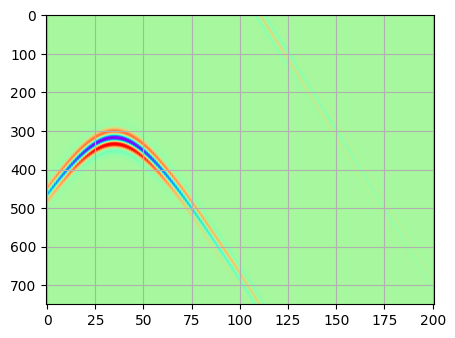

In [19]:
plt.figure(figsize=[5,10])
pclip = .9
which = 2
a_max = pclip*np.amax(datNd[which,:,:])
a_min = pclip*np.amin(datNd[which,:,:])
plt.imshow(np.clip(datNd[which,:,:].T,a_max=a_max, a_min=a_min),cmap='rainbow',aspect=.2)
plt.grid()
plt.show()

In [7]:
image = slow.clone()
born = WEM.Born(slow,data,wave,parObj)

fmin = 1; fmax = 15.3525
nfreq = 44; from imin = 2 to imax = 45
nshots = 3; nrec = 201


In [8]:
# imnd = image.getNdArray()
# imnd[n2//2, n1//2] = 1
born.forward(False,image, data)

Forward born ... 
53.0266 s


In [9]:
born.adjoint(False,image,data)

Adjoint born ... 
68.1106 s


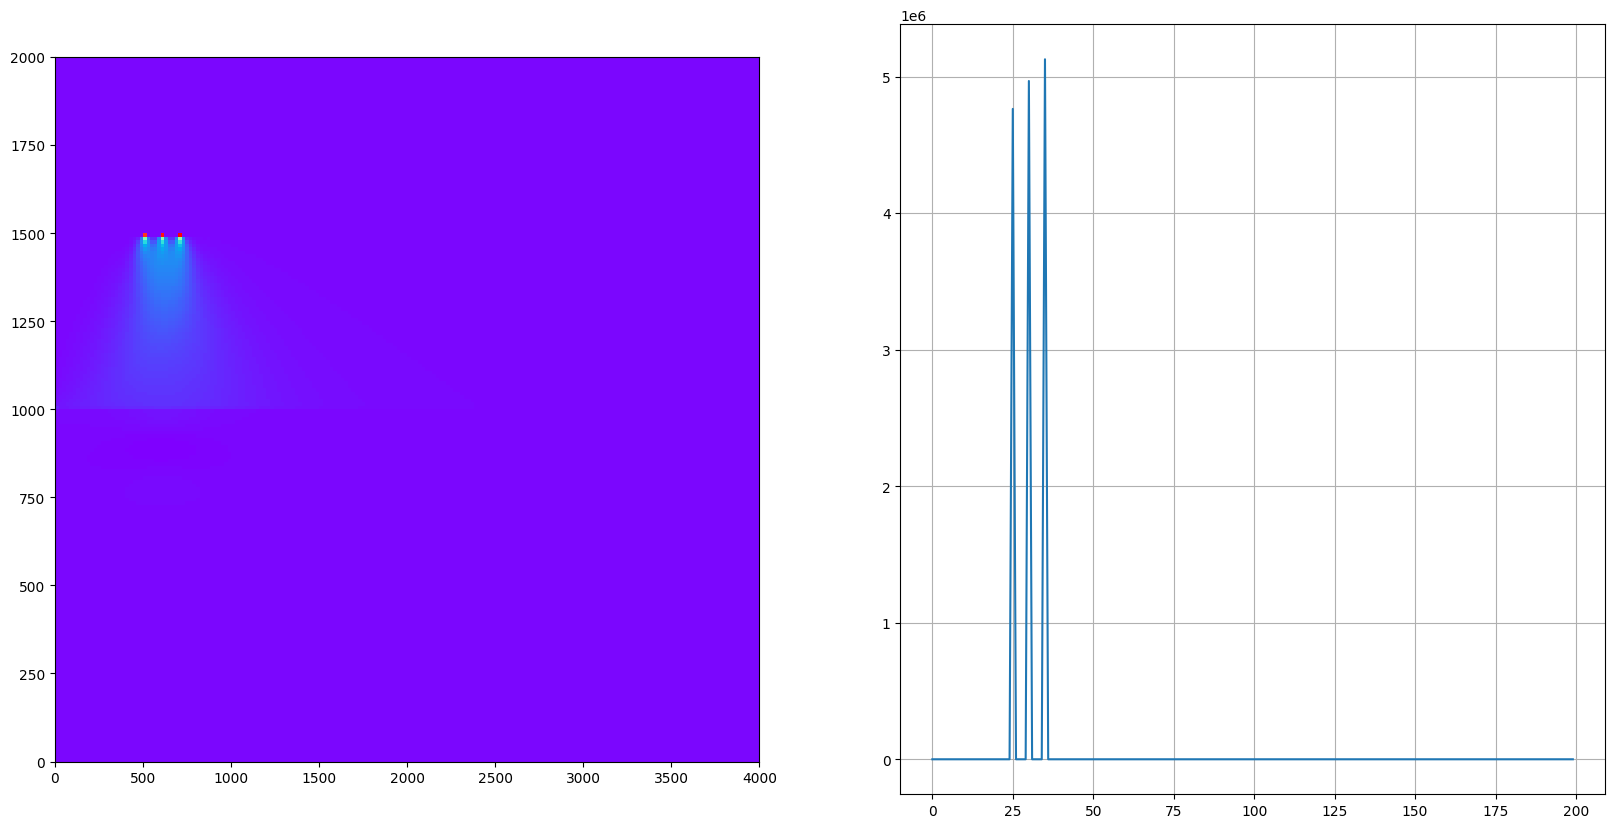

In [10]:
imNd = image.getNdArray().real

fig, ax = plt.subplots(1,2,figsize=[20,10])
ax[0].imshow(image.getNdArray().real,cmap='rainbow',extent=[0,4000,0,2000],aspect=2)
ax[1].plot(imNd[50, :])
ax[1].grid()
plt.show()

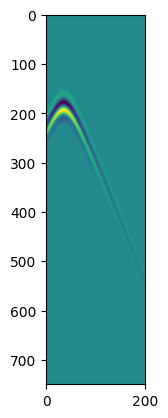

In [11]:
plt.imshow(data[2,:,:].T)

# Wrong bg

Adjoint born ... 
62.3733 s


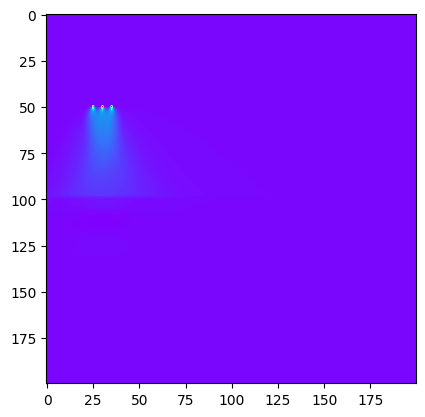

In [12]:
bg = slow.clone()
bg.getNdArray()[:] *= 0.95
born.setBgSlow(bg)
born.adjoint(False,image,data)
plt.imshow(image.getNdArray().real,cmap='rainbow')
plt.show()

# Conformal map

In [13]:
import json

cx = n1/2 * d1
cz = n2/2 * d2
r = .75 * min(n2 * d2/2,n1*d1/2)

ns = 2

dic = {}
dic['sx'] = [cx-r, cx]
dic['sz'] = [cz, cz+r]

nr = 101
th = np.linspace(-np.pi, np.pi, nr)
x = cx - r * np.cos(th)
z = cz - r * np.sin(th)
dic['rx'] = x.tolist()
dic['rz'] = z.tolist()

with open('irreg.json','w') as f:
    json.dump(dic,f,indent=4)
    
par = {
    "coord" : 'irreg.json',
    "ns" : ns,
    "dsx" : d1,
    "osx" : 0,
    "dsz" : 0,
    
    "nr" : nr,
    "drx" : d1,
    "orx" : 0,
    "drz" : 0,
    "orz" : 0,
    
    "fmax" : 15,
    "fmin" : 1,   
    
    "nref" : 1,
    "tap" : 0,
    "pad" : 0,
    "ngs" : 0,
    "ngr" : 0,
    "prop" : 'ssf',
    
    "ntaylor" : 1,
    "onepass" : 1,
    "cmap" : 1,
    "eps" : 0,
    "eps_log" : 0.01
}

data = SepVector.getSepVector(Hypercube.hypercube(ns=[nt,par["nr"],par["ns"]],ds=[dt,par["drx"],par["dsx"]],os=[ot,par["orx"],par["osx"]]))
datNd = data.getNdArray()
slowNd[:] = 1/3000 ** 2
parObj = genericIO.pythonParams(par)

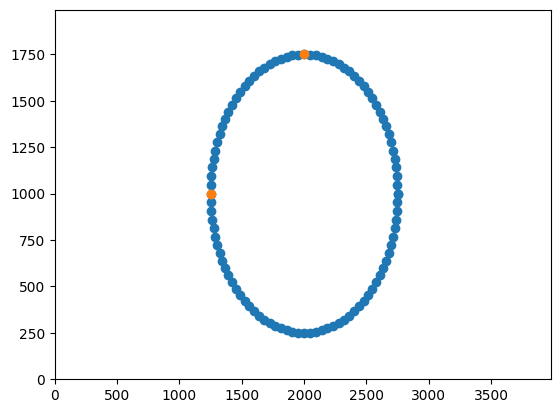

In [14]:
plt.scatter(dic['rx'],dic['rz'])
plt.scatter(dic['sx'],dic['sz'])
plt.xlim([o1,(n1-1)*d1])
plt.ylim([o2,(n2-1)*d2])
plt.show()

In [15]:
wem = WEM.WEM(slow,data,wave,parObj)


fmin = 1; fmax = 15.3525
nfreq = 44; from imin = 2 to imax = 45
nshots = 2; nrec = 101


In [16]:
wem.forward(False,slow,data)

Propagating shots ... 
2.61512 s


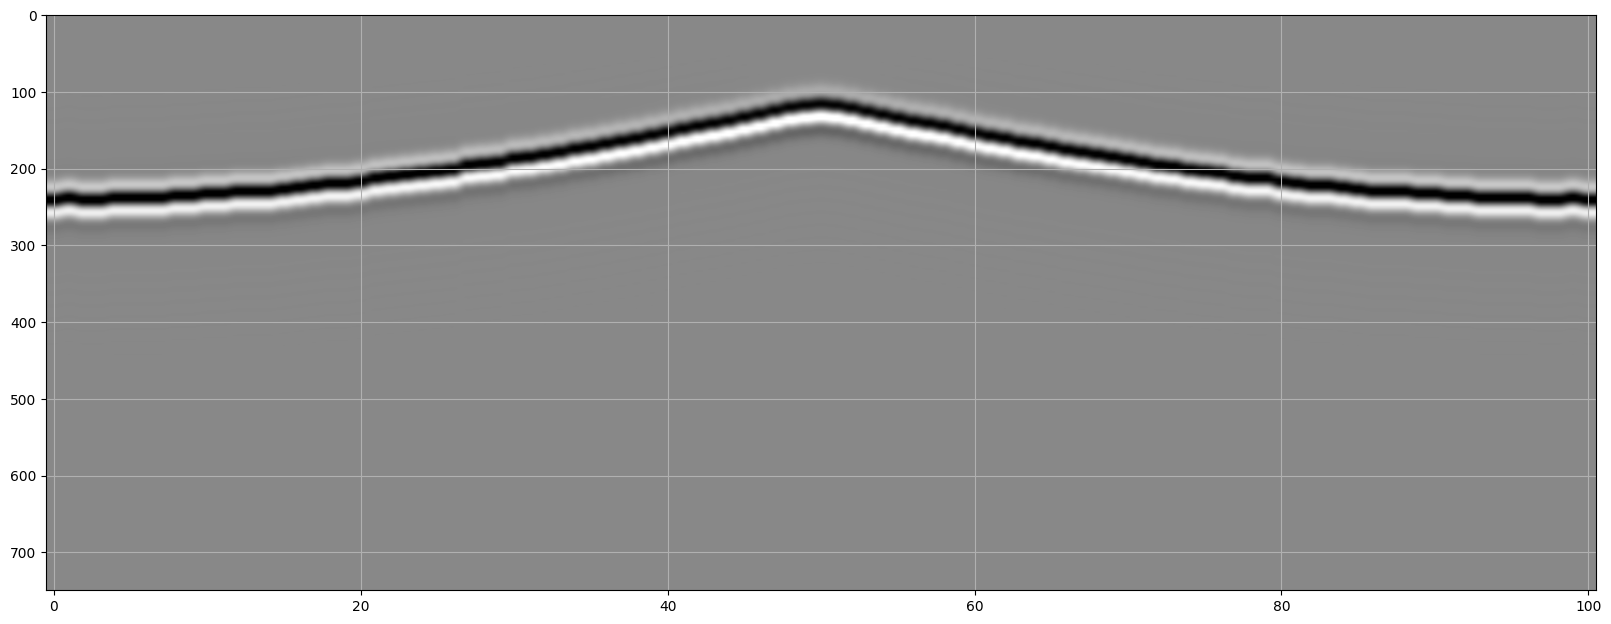

In [17]:
plt.figure(figsize=[20,10])
pclip = .9
which = 0
a_max = pclip*np.amax(datNd[which,:,:])
a_min = pclip*np.amin(datNd[which,:,:])
plt.imshow(np.clip(datNd[which,:,:].T,a_max=a_max, a_min=a_min),cmap='gray',aspect=.05)
plt.grid()
plt.show()


In [18]:
import json

ns = 21

cx = n1/2 * d1
cz = n2/2 * d2
r = .75 * min(n2 * d2/2,n1*d1/2)
th = np.linspace(0,np.pi,ns)
x = cx - r * np.cos(th)
z = cz - r * np.sin(th)

dic = {}
dic['rx'] = x.tolist()
dic['rz'] = z.tolist()
dic['sx'] = x.tolist()
dic['sz'] = z.tolist()
with open('irreg.json','w') as f:
    json.dump(dic,f,indent=4)
    
par = {
    "coord" : 'irreg.json',
    "ns" : ns,
    "dsx" : d1,
    "osx" : 0,
    "dsz" : 0,
    
    "nr" : ns,
    "drx" : d1,
    "orx" : 0,
    "drz" : 0,
    "orz" : 0,
    
    "fmax" : 15,
    "fmin" : 1,   
    
    "nref" : 1,
    "tap" : 0,
    "pad" : 0,
    "ngs" : 3,
    "ngr" : 3,
    "prop" : 'ssf',
    
    "ntaylor" : 1,
    "onepass" : 1,
    "cmap" : 1,
    "eps" : 0.01,
    "eps_log" : 0.01
}

data = SepVector.getSepVector(Hypercube.hypercube(ns=[nt,par["nr"],par["ns"]],ds=[dt,par["drx"],par["dsx"]],os=[ot,par["orx"],par["osx"]]))
datNd = data.getNdArray()
slowNd[:] = 1/2000 ** 2
parObj = genericIO.pythonParams(par)

In [19]:
wem = WEM.WEM(slow,data,wave,parObj)


fmin = 1; fmax = 15.3525
nfreq = 44; from imin = 2 to imax = 45
nshots = 21; nrec = 21


In [20]:
wem.forward(False,slow,data)

Propagating shots ... 
28.416 s


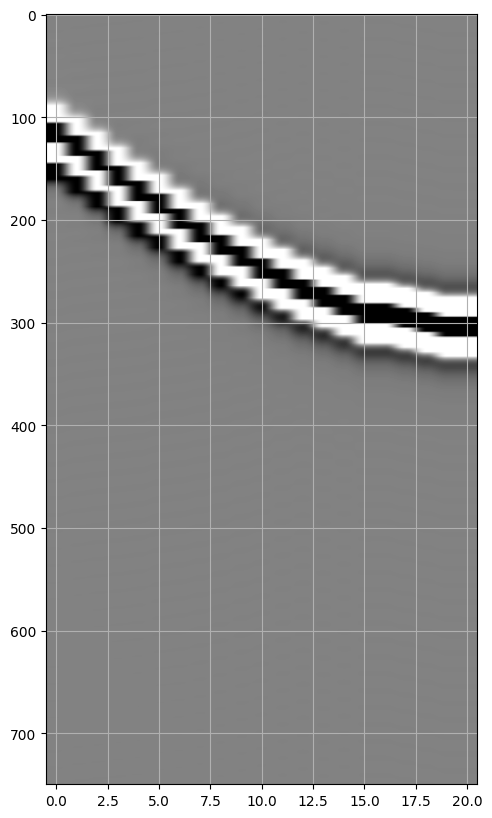

In [21]:
plt.figure(figsize=[20,10])
pclip = .1
which = 0
a_max = pclip*np.amax(datNd[which,:,:])
a_min = pclip*np.amin(datNd[which,:,:])
plt.imshow(np.clip(datNd[which,:,:].T,a_max=a_max, a_min=a_min),cmap='gray',aspect=.05)
plt.grid()
plt.show()


In [22]:
slow.scale(1.1)
res = data.clone()
wem.forward(False,slow,res)
res = res.scaleAdd(data,1,-1)

Propagating shots ... 
29.6884 s


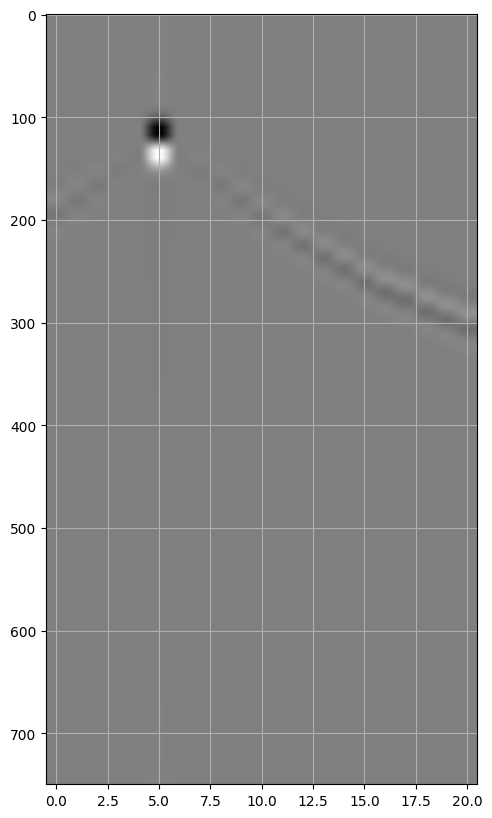

In [23]:
plt.figure(figsize=[20,10])
pclip = .9
which = 5
dat = res.getNdArray()
a_max = pclip*np.amax(dat[which,:,:])
a_min = pclip*np.amin(dat[which,:,:])
plt.imshow(np.clip(dat[which,:,:].T,a_max=a_max, a_min=a_min),cmap='gray',aspect=.05)
plt.grid()
plt.show()

In [24]:
image = slow.clone()
born = WEM.Born(slow,data,wave,parObj)
born.adjoint(False,image,res)

fmin = 1; fmax = 15.3525
nfreq = 44; from imin = 2 to imax = 45
nshots = 21; nrec = 21
Adjoint born ... 
66.0578 s


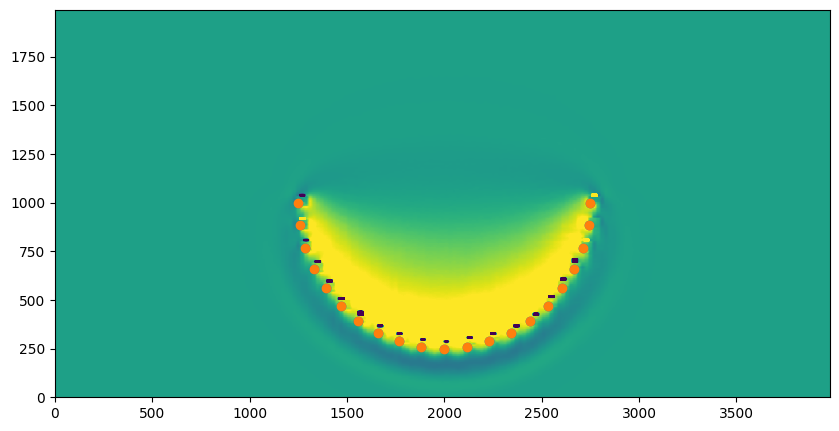

In [31]:
fig = plt.figure(figsize=[10,20])
plt.imshow(image.getNdArray().real, extent=[0,4000,2000,0], vmin=.01*np.amin(image[:].real), vmax=.01*np.amax(image[:].real))
plt.gca().invert_yaxis()

plt.scatter(dic['rx'],dic['rz'])
plt.scatter(dic['sx'],dic['sz'])
plt.xlim([o1,(n1-1)*d1])
plt.ylim([o2,(n2-1)*d2])

# plt.imshow(slowNd.real,extent=[0,4000,0,2000], alpha=.1)

# plt.xlim([150,250])
# plt.ylim([0,50])
plt.show()

## Model with an inclusion

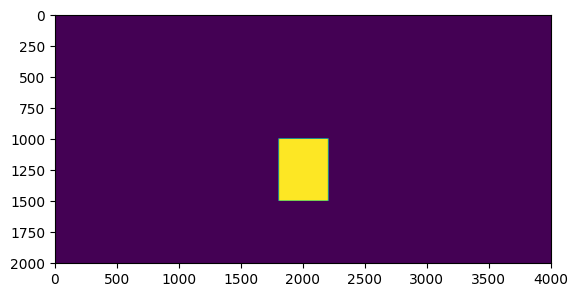

In [26]:
slowNd[int(n2/2)-50:n2//2,int(n1/2)-10:n1//2+10] = 1/1000*1/1000
plt.imshow(slowNd.real,aspect=1, extent=[0,4000,0,2000])
plt.gca().invert_yaxis()
plt.show()

## Test rotation conformal

In [27]:
ang = {
    'a' : np.linspace(np.pi/2, -np.pi/2 ,par['ns']).tolist()
}

with open('angles.json','w') as f:
    json.dump(ang,f,indent=4)

    
par['cmap_angles'] = 'angles.json'
par['cmap'] = 2
par['tap'] = 100
par['pad'] = 100

par['onepass'] = 0

parObj = genericIO.pythonParams(par)

In [28]:
wem.forward(False,slow,data)

Propagating shots ... 
27.6391 s


KeyboardInterrupt: 

In [ ]:
res = data.clone()
wem.forward(False,bg,res)
res = res.scaleAdd(data,1,-1)

In [ ]:
born = WEM.Born(bg,data,wave,parObj)
born.adjoint(False,image,res)

In [ ]:
plt.imshow(image.getNdArray().real,aspect=.3)
plt.xlim([150,250])
# plt.ylim([0,50])
plt.show()

In [ ]:
np.amax(image.getNdArray().real)